# Pressure-fed rocket engine

In [91]:
import os

import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp
from scipy.optimize import root, minimize

import control

import archimedes as arc
from archimedes.experimental import thermo
from archimedes import struct

from modred import balanced_truncation

from engine_model import (
    NitrogenTetroxide,
    MonoMethylHydrazine,
    Engine,
    ControlVolume,
    Orifice,
    Valve,
    LookupTable1D,
    Nozzle,
)

THEME = os.environ.get("ARCHIMEDES_THEME", "dark")
arc.theme.set_theme(THEME)

np.set_printoptions(precision=3, suppress=True)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
BAR_TO_PA = 100000

# Model construction

In [93]:
mmh_eos = MonoMethylHydrazine()
n2o4_eos = NitrogenTetroxide()

In [94]:
# Stoichiometric products at 45 bar as estimated by CEA
# with only products at >0.01% mole fractions
products = {
    "CO": 0.06750,
    "CO2": 0.07985,
    "H": 0.01185,
    "H2": 0.03915,
    "H2O": 0.37163,
    "NO": 0.01693,
    "N2": 0.32306,
    "O": 0.00839,
    "OH": 0.05061,
    "O2": 0.03088,
}

gas_eos = thermo.PerfectGasMixture(composition=products)

In [95]:
# Initialize volumes and orifices

D_fl = 0.006  # Fuel line diameter [m]
A_fl = np.pi * D_fl**2 / 4  # Fuel line cross-sectional area [m^2]
L_fl = 0.02  # Fuel line length [m]
V_fl = L_fl * A_fl  # Fuel line volume [m^3]

A_fm = 1e-4 * 1  # Fuel manifold cross-sectional area [m^2]
V_fm = 1e-6 * 10  # Fuel manifold volume [m^3]
Cd_fmi = 0.7

A_fin = 1e-6 * 0.5  # Fuel manifold cross-sectional area [m^2]
Cd_fin = 0.7

print(f"Fuel line volume: {V_fl:.2e} m^3")
print(f"Fuel line area: {A_fl:.2e} m^2")
print(f"Fuel manifold volume: {V_fm:.2e} m^3")
print(f"Fuel manifold area: {A_fm:.2e} m^2")
print(f"Fuel injector area: {A_fin:.2e} m^2")

A_ol = A_fl
V_ol = A_ol * L_fl
A_om = A_fm
V_om = V_fm
Cd_omi = Cd_fmi
A_oin = 2.5 * A_fin
Cd_oin = Cd_fin

print(f"Ox line volume: {V_ol:.2e} m^3")
print(f"Ox line area: {A_ol:.2e} m^2")
print(f"Ox manifold volume: {V_om:.2e} m^3")
print(f"Ox manifold area: {A_om:.2e} m^2")
print(f"Ox injector area: {A_oin:.2e} m^2")

V_cc = 1e-6 * 50  # Combustor volume [m^3]

At_noz = 1e-4 * 1  # Nozzle throat area [m^2]
Cd_noz = 1.0

I = 1e-6  # Inertance

fuel_line = ControlVolume(vol=V_fl)
fuel_manifold_inlet = Orifice(CdA=Cd_fmi * A_fm, I=I)
fuel_manifold = ControlVolume(vol=V_fm)
fuel_injectors = Orifice(CdA=Cd_fin * A_fin, I=I)

ox_line = ControlVolume(vol=V_ol)
ox_manifold_inlet = Orifice(CdA=Cd_omi * A_om, I=I)
ox_manifold = ControlVolume(vol=V_om)
ox_injectors = Orifice(CdA=Cd_oin * A_oin, I=I)

chamber = ControlVolume(vol=V_cc)
nozzle = Nozzle(At=At_noz, Cq=1.0, I=I)

Fuel line volume: 5.65e-07 m^3
Fuel line area: 2.83e-05 m^2
Fuel manifold volume: 1.00e-05 m^3
Fuel manifold area: 1.00e-04 m^2
Fuel injector area: 5.00e-07 m^2
Ox line volume: 5.65e-07 m^3
Ox line area: 2.83e-05 m^2
Ox manifold volume: 1.00e-05 m^3
Ox manifold area: 1.00e-04 m^2
Ox injector area: 1.25e-06 m^2


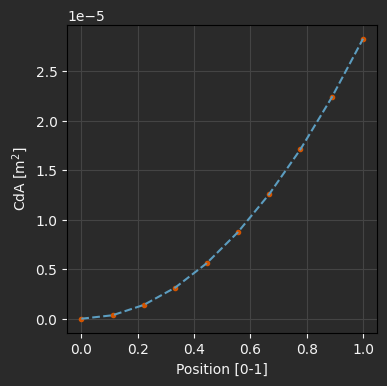

In [96]:
# Simple valve lookup table (same characteristics for both valves)
pos_data = np.linspace(1e-4, 1, 10)
CdA_data = A_fl * pos_data**2  # Quadratic valve characteristics

fuel_valve = Valve(CdA=LookupTable1D(pos_data, CdA_data), I=I)
ox_valve = Valve(CdA=LookupTable1D(pos_data, CdA_data), I=I)

plt.figure(figsize=(4, 4))
plt.plot(pos_data, CdA_data, ".")
plt.plot(pos_data, fuel_valve.CdA(pos_data), "--")
plt.xlabel("Position [0-1]")
plt.ylabel("CdA [m$^2$]")
plt.grid()
plt.show()

In [97]:
model = Engine(
    fuel=mmh_eos,
    oxidizer=n2o4_eos,
    exhaust=gas_eos,
    fv=fuel_valve,
    fl=fuel_line,
    fmi=fuel_manifold_inlet,
    fm=fuel_manifold,
    fin=fuel_injectors,
    ov=ox_valve,
    ol=ox_line,
    omi=ox_manifold_inlet,
    om=ox_manifold,
    oin=ox_injectors,
    cc=chamber,
    noz=nozzle,
)

In [98]:
T0 = 300.0
p0_fl = 60 * BAR_TO_PA
rho0_fl = mmh_eos.rho(p=p0_fl, T=T0)
p0_fm = 60 * BAR_TO_PA
rho0_fm = mmh_eos.rho(p=p0_fm, T=T0)

p0_ol = 60 * BAR_TO_PA
rho0_ol = n2o4_eos.rho(p=p0_ol, T=T0)
p0_om = 60 * BAR_TO_PA
rho0_om = n2o4_eos.rho(p=p0_om, T=T0)

p0_cc = 60 * BAR_TO_PA
T0_cc = 2500.0
rho0_cc = gas_eos.rho(p=p0_cc, T=T0_cc)


def bcs(t):
    pos_fv = np.where(t < 1, 1.0, np.fmax(0.1, 1.0 - (t - 1)))
    pos_ov = np.where(t < 5, 1.0, np.fmax(0.1, 1.0 - (t - 5)))

    return Engine.BoundaryConditions(
        p_ft=90 * BAR_TO_PA * np.ones_like(t),
        T_ft=T0 * np.ones_like(t),
        p_ot=90 * BAR_TO_PA * np.ones_like(t),
        T_ot=T0 * np.ones_like(t),
        p_amb=BAR_TO_PA * np.ones_like(t),
        T_amb=T0 * np.ones_like(t),
        pos_fv=pos_fv,
        pos_ov=pos_ov,
    )


x0 = Engine.State(
    fv=Valve.State(dm=0.05),
    fl=ControlVolume.State(rho=rho0_fl, T=T0),
    fmi=Orifice.State(dm=0.05),
    fm=ControlVolume.State(rho=rho0_fm, T=T0),
    fin=Orifice.State(dm=0.05),
    ov=Valve.State(dm=0.15),
    ol=ControlVolume.State(rho=rho0_ol, T=T0),
    omi=Orifice.State(dm=0.15),
    om=ControlVolume.State(rho=rho0_om, T=T0),
    oin=Orifice.State(dm=0.15),
    cc=ControlVolume.State(rho=rho0_cc, T=T0),
    noz=Orifice.State(dm=0.2),
)

u0 = bcs(0.0)

model.dynamics(x0, u0)

Engine.State(fv=FlowPath.State(dm=np.float64(2998217289421.2397)), fl=ControlVolume.State(rho=0.0, T=np.float64(167.73462811550834)), fmi=FlowPath.State(dm=np.float64(-291266049.41949266)), fm=ControlVolume.State(rho=0.0, T=np.float64(0.0)), fin=FlowPath.State(dm=np.float64(-6370641976779.759)), ov=FlowPath.State(dm=np.float64(2990244177605.729)), ol=ControlVolume.State(rho=0.0, T=np.float64(0.0)), omi=FlowPath.State(dm=np.float64(-1597092234.7223659)), om=ControlVolume.State(rho=0.0, T=np.float64(0.0)), oin=FlowPath.State(dm=np.float64(-4941390302223.184)), cc=ControlVolume.State(rho=0.0, T=np.float64(2046704.9921469258)), noz=FlowPath.State(dm=np.float64(-615218998971.541)))

In [99]:
x0_flat, unravel = arc.tree.ravel(x0)
x0_flat

array([   0.05 ,  875.839,  300.   ,    0.05 ,  875.839,  300.   ,
          0.05 ,    0.15 , 1437.562,  300.   ,    0.15 , 1437.562,
        300.   ,    0.15 ,    6.778,  300.   ,    0.2  ])

In [100]:
@arc.compile
def ode_rhs(t, x_flat):
    x = unravel(x_flat)
    u = bcs(t)
    x_t = model.dynamics(x, u)
    x_t_flat, _ = arc.tree.ravel(x_t)
    return x_t_flat


jac = arc.jac(ode_rhs, 1)

In [101]:
dx0 = unravel(ode_rhs(0.0, x0_flat))
dx0.cc

ControlVolume.State(rho=array(0.), T=array(2046704.992))

In [102]:
# jac(0.0, x0_flat)

In [103]:
def _ode_rhs(t, x):
    return ode_rhs(t, x)


def _jac(t, x):
    J = jac(t, x)
    return J


sol = solve_ivp(
    _ode_rhs,
    t_span=(0, 10),
    y0=x0_flat,
    method="BDF",
    jac=_jac,
    atol=1e-9,
    rtol=1e-6,
)

sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  8.481e-19 ...  9.868e+00  1.000e+01]
        y: [[ 5.000e-02  5.000e-02 ...  2.731e-02  2.731e-02]
            [ 8.758e+02  8.758e+02 ...  8.730e+02  8.730e+02]
            ...
            [ 3.000e+02  3.000e+02 ...  3.430e+03  3.430e+03]
            [ 2.000e-01  2.000e-01 ...  7.164e-02  7.164e-02]]
      sol: None
 t_events: None
 y_events: None
     nfev: 4002
     njev: 148
      nlu: 471

In [104]:
leaves, treedef = arc.tree.flatten(x0)
ts = sol.t
xs = treedef.unflatten(sol.y)
us = bcs(ts)

In [105]:
xs.fin.dm[-1], xs.oin.dm[-1]

(np.float64(0.027309958203148306), np.float64(0.04433087406717141))

In [106]:
dm_f = np.interp(1.0, ts, xs.fin.dm)
dm_o = np.interp(1.0, ts, xs.oin.dm)

print(f"fuel     = {dm_f:.4f} kg/s")
print(f"oxidizer = {dm_o:.4f} kg/s")
print(f"net      = {dm_f + dm_o:.4f} kg/s")

fuel     = 0.0371 kg/s
oxidizer = 0.1189 kg/s
net      = 0.1560 kg/s


In [107]:
xs.cc.T[-1]

np.float64(3430.1324913449284)

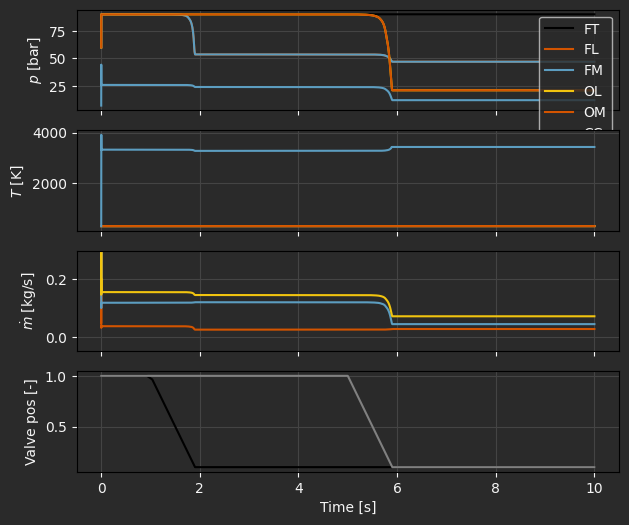

In [108]:
p_fl = np.array([mmh_eos.p(rho=rho, T=T) for rho, T in zip(xs.fl.rho, xs.fl.T)])
p_fm = np.array([mmh_eos.p(rho=rho, T=T) for rho, T in zip(xs.fm.rho, xs.fm.T)])
p_ol = np.array([n2o4_eos.p(rho=rho, T=T) for rho, T in zip(xs.ol.rho, xs.ol.T)])
p_om = np.array([n2o4_eos.p(rho=rho, T=T) for rho, T in zip(xs.om.rho, xs.om.T)])
p_cc = np.array([gas_eos.p(rho=rho, T=T) for rho, T in zip(xs.cc.rho, xs.cc.T)])

fig, ax = plt.subplots(4, 1, figsize=(7, 6), sharex=True)
ax[0].plot(ts, us.p_ft / BAR_TO_PA, c="k", label="FT")
ax[0].plot(ts, p_fl / BAR_TO_PA, label="FL")
ax[0].plot(ts, p_fm / BAR_TO_PA, label="FM")
ax[0].plot(ts, p_ol / BAR_TO_PA, label="OL")
ax[0].plot(ts, p_om / BAR_TO_PA, label="OM")
ax[0].plot(ts, p_cc / BAR_TO_PA, label="CC")
ax[0].legend()
ax[0].set_ylabel("$p$ [bar]")
ax[0].grid()
ax[1].plot(ts, xs.fl.T)
ax[1].plot(ts, xs.fm.T)
ax[1].plot(ts, xs.ol.T)
ax[1].plot(ts, xs.om.T)
ax[1].plot(ts, xs.cc.T)
ax[1].set_ylabel("$T$ [K]")
ax[1].grid()
ax[2].plot(ts, xs.fv.dm)
# ax[2].plot(ts, xs.fmi.dm)
# ax[2].plot(ts, xs.fin.dm)
ax[2].plot(ts, xs.ov.dm)
# ax[2].plot(ts, xs.omi.dm)
# ax[2].plot(ts, xs.oin.dm)
ax[2].plot(ts, xs.noz.dm)
ax[2].set_ylabel(r"$\dot{m}$ [kg/s]")
ax[2].grid()
ax[2].set_ylim([-0.05, 0.3])
ax[3].plot(ts, us.pos_fv, "k-", label="Fuel")
ax[3].plot(ts, us.pos_ov, "-", c="grey", label="Ox")
ax[3].set_ylabel("Valve pos [-]")
ax[3].grid()
ax[-1].set_xlabel("Time [s]")
plt.show()

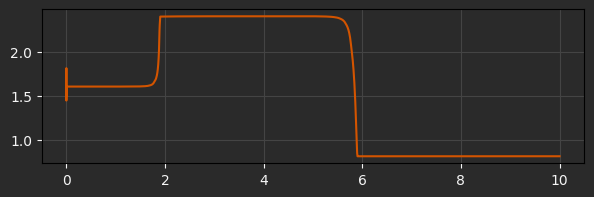

In [109]:
# Mixture ratio

dn_o = xs.oin.dm / (model.oxidizer.M * 1e-3)  # molar flow rate of oxidizer
dn_f = xs.fin.dm / (model.fuel.M * 1e-3)  # molar flow rate of fuel

plt.figure(figsize=(7, 2))
plt.plot(ts, dn_o / dn_f)
plt.grid()

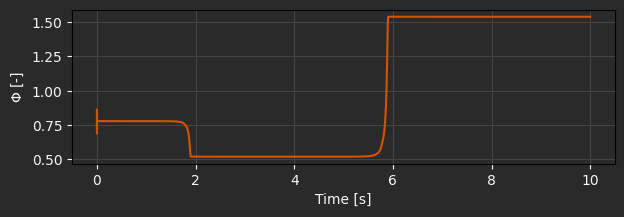

In [110]:
Phi = model.equivalence_ratio(xs)
g0 = 9.81  # m/s^2

plt.figure(figsize=(7, 2))
plt.plot(ts, Phi)
plt.xlabel("Time [s]")
plt.ylabel(r"$\Phi$ [-]")
plt.grid()
plt.show()

### Thrust calculation

Specific impulse at max thrust: 245.56 s
Thrust: 375.71 N


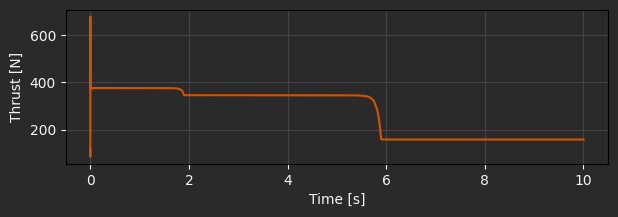

In [111]:
F = model.thrust(xs, us)
g0 = 9.81  # m/s^2

# Exhaust mass flow rate [kg/s]
dm_e = xs.noz.dm

# Specific impulse at max thrust [s]
Isp = np.interp(1.0, ts, F / dm_e) / g0
print(f"Specific impulse at max thrust: {Isp:.2f} s")

print(f"Thrust: {np.interp(1.0, ts, F):.2f} N")

plt.figure(figsize=(7, 2))
plt.plot(ts, F)
plt.xlabel("Time [s]")
plt.ylabel("Thrust [N]")
plt.grid()
plt.show()

# Fixed-point finding

Given a target thrust and mixture ratio, find an equilibrium operating point.

In [112]:
from typing import OrderedDict

lbx = Engine.State(
    fv=Valve.State(dm=0.0),
    fl=ControlVolume.State(rho=800, T=290),
    fmi=Orifice.State(dm=0.0),
    fm=ControlVolume.State(rho=800, T=290),
    fin=Orifice.State(dm=0.0),
    ov=Valve.State(dm=0.0),
    ol=ControlVolume.State(rho=1000, T=290),
    omi=Orifice.State(dm=0.0),
    om=ControlVolume.State(rho=1000, T=290),
    oin=Orifice.State(dm=0.0),
    cc=ControlVolume.State(rho=0.1, T=3000),
    noz=Orifice.State(dm=0.0),
)

ubx = Engine.State(
    fv=Valve.State(dm=0.2),
    fl=ControlVolume.State(rho=1200, T=350),
    fmi=Orifice.State(dm=0.2),
    fm=ControlVolume.State(rho=1200, T=350),
    fin=Orifice.State(dm=0.2),
    ov=Valve.State(dm=0.2),
    ol=ControlVolume.State(rho=2000, T=350),
    omi=Orifice.State(dm=0.2),
    om=ControlVolume.State(rho=2000, T=350),
    oin=Orifice.State(dm=0.2),
    cc=ControlVolume.State(rho=10.0, T=5000),
    noz=Orifice.State(dm=0.5),
)

lbu = OrderedDict(
    {
        "pos_ov": 0.0,
        "pos_fv": 0.0,
    }
)

ubu = OrderedDict(
    {
        "pos_ov": 1.0,
        "pos_fv": 1.0,
    }
)

In [113]:
u_valve = OrderedDict(
    {
        "pos_ov": 1.0,
        "pos_fv": 1.0,
    }
)  # Valve positions


# Boundary conditions
u0 = bcs(ts[-1])

# x_guess = arc.tree.map(lambda x: np.interp(0.99, ts, x), xs)

dvs_guess = (x0, u_valve)
dvs_guess_flat, unravel = arc.tree.ravel(dvs_guess)

lb_flat, _ = arc.tree.ravel((lbx, lbu))
ub_flat, _ = arc.tree.ravel((ubx, ubu))


@arc.compile
def residual(dvs_flat):
    x, u_valve = unravel(dvs_flat)
    u = u0.replace(**u_valve)
    OF_cmd = model.OF_stoich
    residuals = (model.dynamics(x, u), model.OF(x) - OF_cmd)
    return arc.tree.ravel(residuals)[0]


F_cmd = 300.0

residual(dvs_guess_flat)

array([ 2.998e+12,  0.000e+00,  1.677e+02, -2.913e+08,  0.000e+00,
        0.000e+00, -6.371e+12,  2.990e+12,  0.000e+00,  0.000e+00,
       -1.597e+09,  0.000e+00,  0.000e+00, -4.941e+12,  0.000e+00,
        2.047e+06, -6.152e+11,  5.036e-01])

In [114]:
@arc.compile
def obj(dvs_flat):
    x, u_valve = unravel(dvs_flat)
    u = u0.replace(**u_valve)
    F = model.thrust(x, u)

    J = (F - F_cmd) ** 2  # Target thrust
    # J = -F  # Maximize thrust
    return J

In [115]:
obj(dvs_guess_flat)

array(33669.624)

In [116]:
options = {
    # "ipopt.max_iter": 1000,
    # "ipopt.tol": 1e-2,
    # "ipopt.constr_viol_tol": 1e-6,
    # "ipopt.hessian_approximation": "limited-memory",
}

dvs_opt_flat = arc.minimize(
    obj,
    dvs_guess_flat,
    constr=residual,
    bounds=(lb_flat, ub_flat),
    **options,
)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:       71
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       61

Total number of variables............................:       19
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       19
                     variables with only upper bounds:        0
Total number of equality constraints.................:       18
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.1893825e+04 1.29e+13 2.80e-02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

In [117]:
obj(dvs_opt_flat)

array(0.)

In [118]:
residual(dvs_opt_flat)

array([-0.032,  0.   , -0.   ,  0.106,  0.   ,  0.   , -0.075,  0.052,
        0.   ,  0.   , -0.002,  0.   ,  0.   , -0.051,  0.   ,  0.   ,
        0.   ,  0.   ])

In [119]:
x_opt, u_valve_opt = unravel(dvs_opt_flat)

u_opt = u0.replace(**u_valve_opt)

u_valve_opt

OrderedDict([('pos_fv', array(0.18)), ('pos_ov', array(0.175))])

In [120]:
F_max = model.thrust(x_opt, u_opt)

# Exhaust mass flow rate [kg/s]
dm_e = x_opt.noz.dm

# Specific impulse at max thrust [s]
Isp = F_max / (dm_e * g0)

print(f"Thrust: {F_max:.2f} N")
print(f"Isp: {Isp:.2f} s")

Thrust: 300.00 N
Isp: 241.11 s


# Control

In [121]:
x0_flat, unravel_state = arc.tree.ravel(x_opt)
u0_flat, unravel_input = arc.tree.ravel(u_valve_opt)
y0_flat = np.stack([F_max, model.OF_stoich])

n, m, p = x0_flat.size, u0_flat.size, y0_flat.size


@arc.compile
def dyn(x_flat, u_flat):
    x = unravel_state(x_flat)
    u_valve = unravel_input(u_flat)
    u = u0.replace(**u_valve)
    x_t = model.dynamics(x, u)
    x_t_flat, _ = arc.tree.ravel(x_t)
    return x_t_flat


@arc.compile
def obs(x_flat, u_flat):
    x = unravel_state(x_flat)
    u_valve = unravel_input(u_flat)
    u = u0.replace(**u_valve)
    F = model.thrust(x, u)
    OF = model.OF(x)
    return np.stack([F, OF])

### Open-loop control algorithm

1. Look up fuel valve position from thrust command
2. Look up ox valve position to match $\Phi = 1$

In [122]:
@arc.compile
def residual(dvs_flat, pos_fv):
    x, u_valve = unravel(dvs_flat)
    u_valve["pos_fv"] = pos_fv
    u = u0.replace(**u_valve)
    OF_cmd = model.OF_stoich
    residuals = (model.dynamics(x, u), model.OF(x) - OF_cmd)
    return arc.tree.ravel(residuals)[0]

In [123]:
dvs_guess = (x_opt, {"pos_ov": u_opt.pos_ov})
dvs_guess_flat, unravel = arc.tree.ravel(dvs_guess)
u_cmd_fv = np.linspace(1e-1, 1, 100)

x_cmd = np.zeros((len(u_cmd_fv), n))
u_cmd = np.zeros((len(u_cmd_fv), m))
u_cmd_ov = np.zeros((len(u_cmd_fv), 1))

for i in range(len(u_cmd_fv) - 1, -1, -1):
    dvs_cmd_flat = arc.root(
        residual, dvs_guess_flat, args=(u_cmd_fv[i],), method="kinsol"
    )
    x_cmd[i], u_cmd_ov[i] = dvs_cmd_flat[:n], dvs_cmd_flat[n:]
    u_cmd[i] = [u_cmd_fv[i], u_cmd_ov[i, 0]]
    dvs_guess_flat, _ = arc.tree.ravel((x_cmd[i], u_cmd_ov[i]))
    if np.any(np.isnan(dvs_cmd_flat)):
        raise ValueError("NaN detected in optimization")

u_cmd_ov = u_cmd_ov.squeeze()

In [124]:
T_cmd = np.zeros_like(u_cmd_fv)

for i in range(len(u_cmd_fv)):
    T_cmd[i] = obs(x_cmd[i], u_cmd[i])[0]

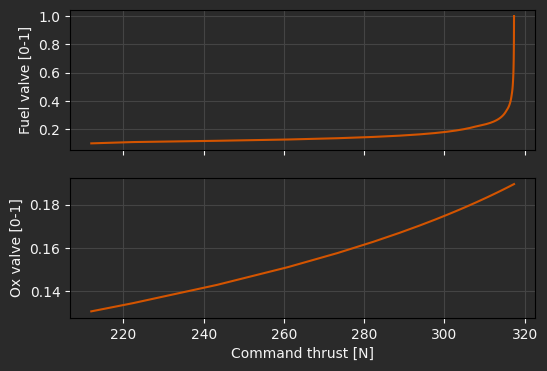

In [125]:
fig, ax = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
ax[0].plot(T_cmd, u_cmd_fv)
ax[0].grid()
ax[0].set_ylabel("Fuel valve [0-1]")
ax[1].plot(T_cmd, u_cmd_ov)
ax[1].grid()
ax[1].set_ylabel("Ox valve [0-1]")
ax[-1].set_xlabel("Command thrust [N]")
plt.show()

In [126]:
@arc.compile
def ctrl(T):
    return {
        "pos_fv": np.interp(T, T_cmd, u_cmd_fv),
        "pos_ov": np.interp(T, T_cmd, u_cmd_ov),
    }

### Simulate with a step input

In [127]:
t0, tf = 0.0, 2.0
t_data = np.array([t0, 1 - 1e-6, 1 + 1e-6, tf])
F_data = np.where(t_data < 1, 300, 301)


def thrust(t):
    return np.interp(t, t_data, F_data)

In [128]:
u_nominal = ctrl(thrust(t0))

# Interpolation for initial guess
x0_flat = np.array(
    [np.interp(u_nominal["pos_fv"], u_cmd_fv, x_cmd[:, i]) for i in range(n)]
)


# Root-finding for the initial state
@arc.compile
def residual(x_flat):
    x = unravel_state(x_flat)
    u = u0.replace(**u_nominal)
    return arc.tree.ravel(model.dynamics(x, u))[0]


x0_flat = arc.root(residual, x0_flat, method="kinsol")

In [129]:
@arc.compile
def ode_rhs(t, x_flat):
    x = unravel_state(x_flat)
    u = u0.replace(**ctrl(thrust(t)))
    x_t = model.dynamics(x, u)
    x_t_flat, _ = arc.tree.ravel(x_t)
    return x_t_flat


jac = arc.jac(ode_rhs, 1)

ode_rhs(0.0, x0_flat)

array([ 0.043,  0.   ,  0.   ,  0.038,  0.   ,  0.   , -0.082,  0.049,
        0.   ,  0.   , -0.105,  0.   ,  0.   ,  0.055, -0.   , -0.   ,
       -0.   ])

In [130]:
def _ode_rhs(t, x):
    return ode_rhs(t, x)


def _jac(t, x):
    J = jac(t, x)
    return J


sol = solve_ivp(
    _ode_rhs,
    t_span=(0, 2),
    y0=x0_flat,
    method="BDF",
    jac=_jac,
    atol=1e-9,
    rtol=1e-6,
)

sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  7.487e-12 ...  1.911e+00  2.000e+00]
        y: [[ 3.628e-02  3.628e-02 ...  3.639e-02  3.639e-02]
            [ 8.768e+02  8.768e+02 ...  8.768e+02  8.768e+02]
            ...
            [ 3.360e+03  3.360e+03 ...  3.360e+03  3.360e+03]
            [ 1.268e-01  1.268e-01 ...  1.272e-01  1.272e-01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 525
     njev: 21
      nlu: 102

In [131]:
leaves, treedef = arc.tree.flatten(x0)
ts = sol.t
xs = treedef.unflatten(sol.y)
us = bcs(ts)

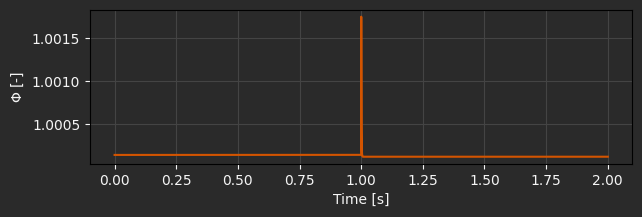

In [132]:
Phi = model.equivalence_ratio(xs)
g0 = 9.81  # m/s^2

plt.figure(figsize=(7, 2))
plt.plot(ts, Phi)
plt.xlabel("Time [s]")
plt.ylabel(r"$\Phi$ [-]")
plt.grid()
plt.show()

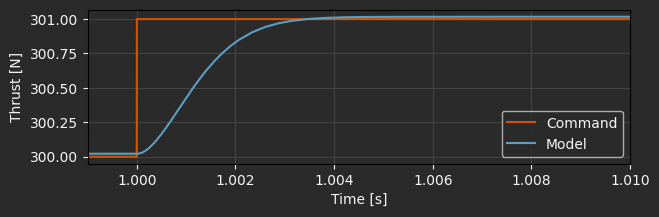

In [133]:
F = model.thrust(xs, us)

plt.figure(figsize=(7, 2))
plt.plot(t_data, F_data, label="Command")
plt.plot(ts, F, "-", label="Model")
plt.xlabel("Time [s]")
plt.ylabel("Thrust [N]")
plt.grid()
plt.legend()
plt.xlim([1 - 1e-3, 1 + 1e-2])
plt.show()

2-3 ms response time

### Linearize about the operating point

In [134]:
print(y0_flat)
print(obs(x0_flat, u0_flat))

A = arc.jac(dyn, 0)(x0_flat, u0_flat)
B = arc.jac(dyn, 1)(x0_flat, u0_flat)
C = arc.jac(obs, 0)(x0_flat, u0_flat)
D = arc.jac(obs, 1)(x0_flat, u0_flat)

print(np.allclose(D, 0))

[300.      2.496]
[300.021   2.496]
True


In [135]:
A.shape[0]

17

In [136]:
# Eigenvalues of the linearized system
evals, evecs = np.linalg.eig(A)

# Sort by descending real part
sort_idx = np.argsort(evals.real)[::-1]
evals = evals[sort_idx]
evecs = evecs[:, sort_idx]

evals

array([-6.143e-03   +0.j  , -1.057e-01   +0.j  , -4.137e+00   +0.j  ,
       -7.318e+01   +0.j  , -1.359e+03   +0.j  , -1.492e+03-1070.54j,
       -1.492e+03+1070.54j, -6.138e+03   +0.j  , -9.379e+07   +0.j  ,
       -5.685e+08   +0.j  , -7.876e+09   +0.j  , -1.276e+10   +0.j  ,
       -3.345e+13   +0.j  , -4.151e+13   +0.j  , -6.962e+13   +0.j  ,
       -8.229e+13   +0.j  , -3.378e+14   +0.j  ])

In [137]:
# Least-stable eigenvector
v1 = unravel_state(evecs[:, 0])
fields = struct.fields(v1)

for field in fields:
    print(f"{field.name}: {getattr(v1, field.name)}")

# The slow eigenvector is mainly associated with temperature changes
# -> not mass flow

fv: FlowPath.State(dm=array(0.))
fl: ControlVolume.State(rho=array(-0.), T=array(-0.691))
fmi: FlowPath.State(dm=array(0.))
fm: ControlVolume.State(rho=array(-0.), T=array(-0.652))
fin: FlowPath.State(dm=array(0.))
ov: FlowPath.State(dm=array(-0.))
ol: ControlVolume.State(rho=array(0.002), T=array(-0.001))
omi: FlowPath.State(dm=array(-0.))
om: ControlVolume.State(rho=array(-0.14), T=array(0.06))
oin: FlowPath.State(dm=array(-0.))
cc: ControlVolume.State(rho=array(0.), T=array(-0.273))
noz: FlowPath.State(dm=array(-0.))


### Region of validity for the linear system

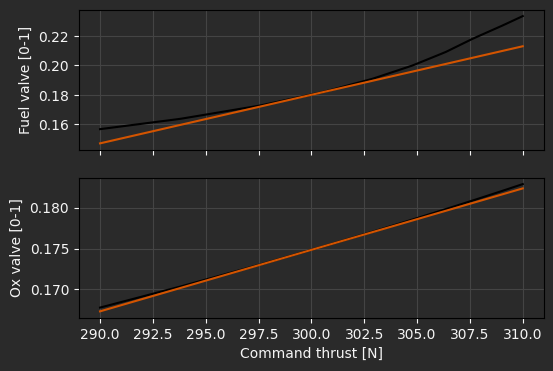

In [138]:
n, m, p = A.shape[0], B.shape[1], C.shape[0]

F_cmd = np.linspace(290, 310, 100)
OF_cmd = model.OF_stoich * np.ones_like(F_cmd)

y_cmd = np.stack([F_cmd, OF_cmd], axis=1) - y0_flat

# Solve the linear system to find the predicted operating point
M = np.concatenate(
    [
        np.concatenate([A, B], axis=1),
        np.concatenate([C, D], axis=1),
    ],
    axis=0,
)

x_cmd = np.zeros((len(F_cmd), n))
u_cmd = np.zeros((len(F_cmd), m))

for i in range(len(F_cmd)):
    # Find a fixed point with the target outputs and zero time derivative
    b = np.concatenate([np.zeros(n), y_cmd[i]])
    z = np.linalg.solve(M, b)
    x_cmd[i], u_cmd[i] = z[:n], z[n:]


# Shift by the fixed point
x_cmd_nl = x_cmd + x0_flat
u_cmd_nl = u_cmd + u0_flat

# Lookup table for nonlinear set point
u_cmd_lut = ctrl(F_cmd)

fig, ax = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
ax[0].plot(F_cmd, u_cmd_lut["pos_fv"], "k")
ax[0].plot(F_cmd, u_cmd_nl[:, 0])
ax[0].grid()
ax[0].set_ylabel("Fuel valve [0-1]")
ax[1].plot(F_cmd, u_cmd_lut["pos_ov"], "k")
ax[1].plot(F_cmd, u_cmd_nl[:, 1])
ax[1].grid()
ax[1].set_ylabel("Ox valve [0-1]")
ax[-1].set_xlabel("Command thrust [N]")
plt.show()

In [139]:
# Transfer function from valves to thrust
sys = control.StateSpace(A, B, C[:1, :], D[:1, :])


def freq_response(sys, omega):
    mag, phase, _omega = control.frequency_response(sys, omega=omega)

    for i in range(phase.shape[0]):
        for j in range(phase.shape[1]):
            phase[i, j] = control.ctrlutil.unwrap(phase[i, j])

    return mag, phase


omega = np.logspace(-1, 7, 200)
mag, phase = freq_response(sys, omega)

Text(0.5, 1.0, 'Thrust response')

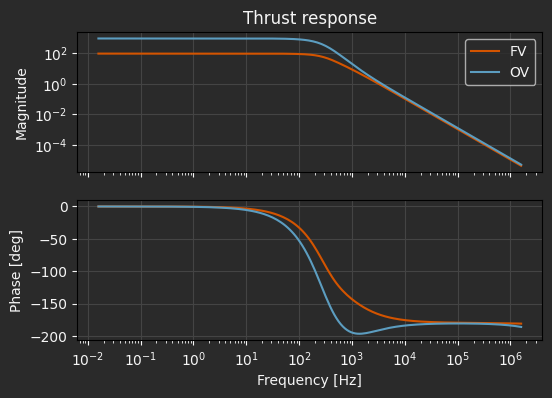

In [140]:
# Convert rad/s to Hz
omega = omega / (2 * np.pi)

fig, ax = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
ax[0].loglog(omega, mag[0, 0], label="FV")
ax[0].loglog(omega, mag[0, 1], label="OV")
ax[0].grid()
ax[0].legend()
ax[0].set_ylabel("Magnitude")
ax[1].semilogx(omega, np.rad2deg(phase[0, 0]), label="FV")
ax[1].semilogx(omega, np.rad2deg(phase[0, 1]), label="OV")
ax[1].grid()
ax[1].set_ylabel("Phase [deg]")
ax[-1].set_xlabel("Frequency [Hz]")
ax[0].set_title("Thrust response")

### Model reduction

In [156]:
Ar, Br, Cr, Dr, hsv = balanced_truncation(sys.A, sys.B, sys.C, sys.D, r=3)
print("Reduced system has ", Ar.shape[0], "states")
rsys = control.StateSpace(Ar, Br, Cr, Dr)

omega = np.logspace(0, 6, 200, base=10)
mag, phase = freq_response(sys, omega)
rmag, rphase = freq_response(rsys, omega)

# Convert rad/s to Hz
omega = omega / (2 * np.pi)

Reduced system has  3 states


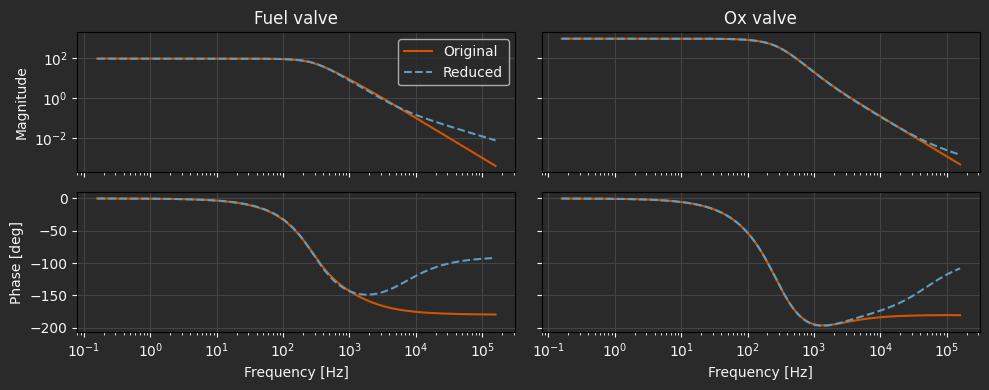

In [157]:
fig, ax = plt.subplots(2, 2, figsize=(10, 4), sharex="col", sharey="row")
ax[0, 0].loglog(omega, mag[0, 0], label="Original")
ax[0, 0].loglog(omega, rmag[0, 0], "--", label="Reduced")
ax[0, 0].grid()
ax[0, 0].legend()
ax[0, 1].loglog(omega, mag[0, 1], label="Original")
ax[0, 1].loglog(omega, rmag[0, 1], "--", label="Reduced")
ax[0, 1].grid()
ax[0, 0].set_ylabel("Magnitude")
ax[1, 0].semilogx(omega, np.rad2deg(phase[0, 0]), label="Original")
ax[1, 0].semilogx(omega, np.rad2deg(rphase[0, 0]), "--", label="Reduced")
ax[1, 0].grid()
ax[1, 0].set_ylabel("Phase [deg]")
ax[1, 0].set_xlabel("Frequency [Hz]")
ax[1, 1].semilogx(omega, np.rad2deg(phase[0, 1]), label="Original")
ax[1, 1].semilogx(omega, np.rad2deg(rphase[0, 1]), "--", label="Reduced")
ax[1, 1].grid()
ax[1, 1].set_xlabel("Frequency [Hz]")
ax[0, 0].set_title("Fuel valve")
ax[0, 1].set_title("Ox valve")
plt.tight_layout()
plt.show()